## predict gene upregulation/downregulation
- Using Expectation Reflection to infer the gene network and predict gene upregulation/downregulation at the next time point
- initial measurements: $t[0-4]$
- final measurements: $t[1-5]$
- midpoint measurements: $\dfrac{t[0-4] + t[1-5])}{2}$

In [1]:
from f_train import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
def ER_inference(X, y, kf=5, regu=0.005):
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    accuracy_v = []
    W_list = []
    h0_list = []
    for (tr_ind, te_ind) in (kfold.split(y)):
        X_tr, y_tr = X[tr_ind], y[tr_ind]
        X_te, y_te = X[te_ind], y[te_ind]
        
        W_full = np.zeros((X_tr.shape[1], y_tr.shape[1]))
        h0_full = np.zeros(y_tr.shape[1])
        accuracy = np.zeros(y_tr.shape[1])
        
        for n in range(y_tr.shape[1]):
            h0, w = fit(X_tr, y_tr[:,n], niter_max=100, regu=0.005)
            W_full[:,n] = w
            h0_full[n] = h0
            h_pred = h0 + X_te.dot(w)
            y_pred = np.sign(h_pred)
            accuracy[n] += accuracy_score(y_te[:,n], y_pred, normalize=False)
        W_list.append(W_full)
        h0_list.append(h0_full)
        accuracy = accuracy/y_te.shape[0]
        accuracy_v.append(accuracy)
    W_avg = np.mean(W_list, axis=0)
    h0_avg = np.mean(h0_list, axis=0)
    return W_list, h0_list, W_avg, h0_avg, np.vstack(accuracy_v)

In [4]:
data_complete = np.loadtxt('../data_complete.txt')
data_init, data_fin, data_midpt, data_deriv = make_data(data_complete, n_bin=6)

names = ["init", "fin", "mid"]
data_list = [data_init, data_fin, data_midpt]
markers = ["o", "x", "+"]

df=list()
for i, data in enumerate(data_list):
    X, y = shuffle(data, data_deriv)
    W_list, h0_list, W_avg, h0_avg, accuracy_v = ER_inference(X, y, kf=5, regu=0.005)
    with open('./pickles/W_list_'+names[i]+'.pkl', 'wb') as f:
        pickle.dump(W_list, f)
    with open('./pickles/W_avg_'+names[i]+'.pkl', 'wb') as f:
        pickle.dump(W_avg, f)
    df.append(accuracy_v)

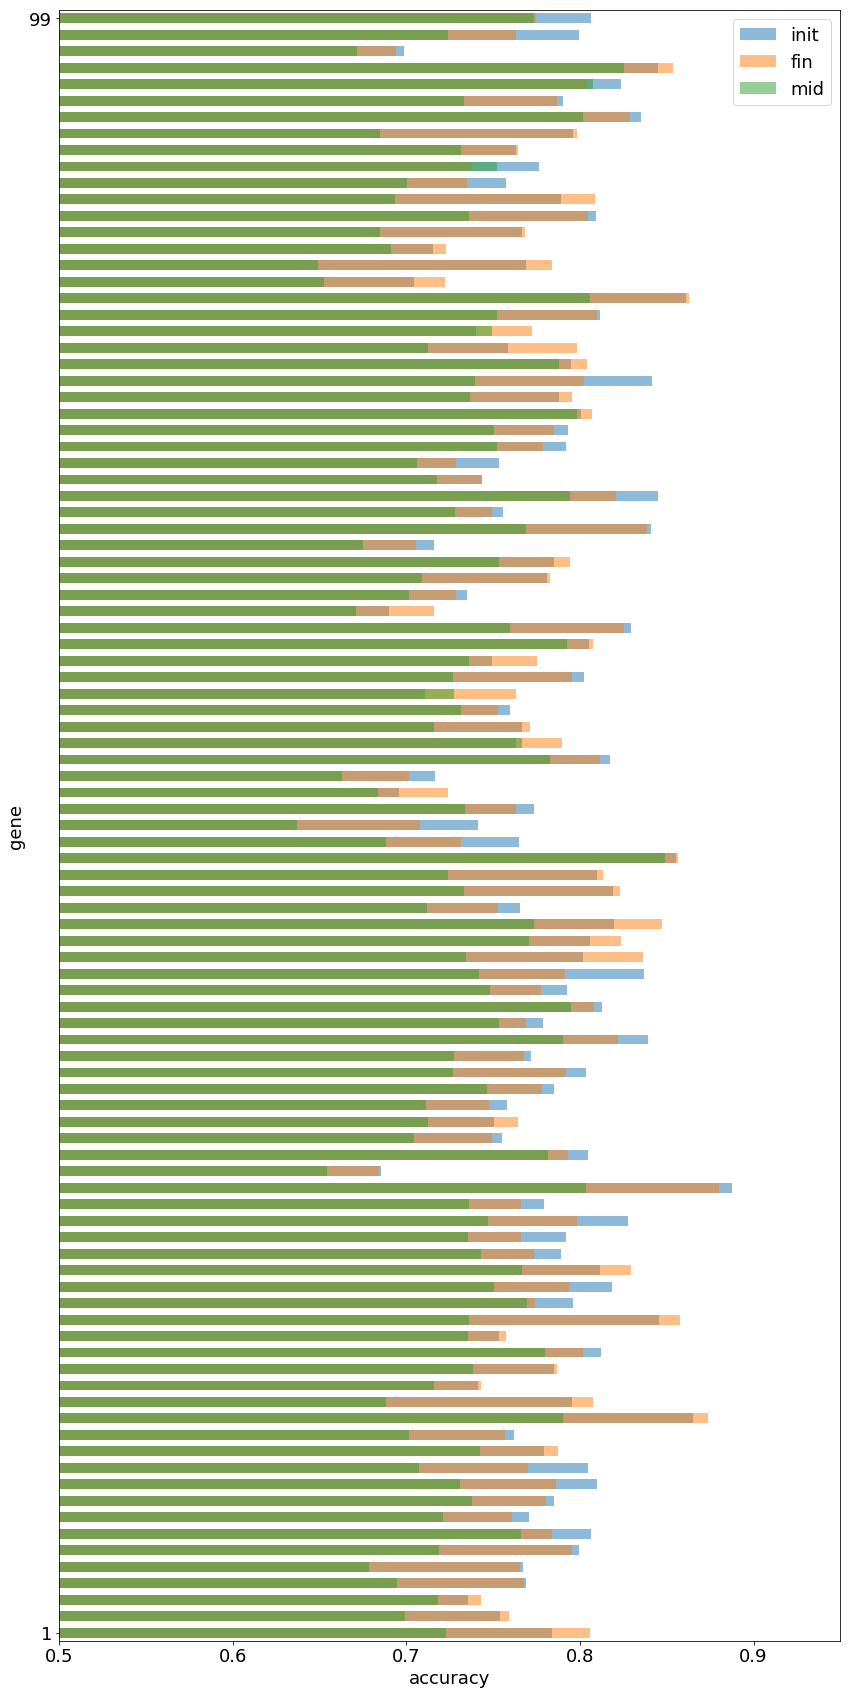

In [5]:
fig = plt.figure(figsize=(14,30))
plt.rcParams['font.size'] = 18
plt.xlabel('accuracy')
plt.ylabel('gene')
plt.yticks([0, 98*2], ['1','99'])
plt.xticks(np.arange(0.5, 0.95, step=0.1))
plt.ylim([-1,98*2+1])
plt.xlim([0.5,0.95])

for i, pred in enumerate(df):
    plt.barh(np.array(range(pred.shape[1]))*2, pred.mean(axis=0), height=1.2, alpha=0.5, label=names[i])
plt.legend(loc=1)
plt.show()

In [6]:
for i, pred in enumerate(df):
    print(names[i], ": ", pred.mean(), pred.std())


init :  0.784259840923217 0.040498145972490004
fin :  0.7813930685598999 0.03964106723754832
mid :  0.734635263460535 0.04097741279043603


p = 0
p = 0
p = 6.05215e-65


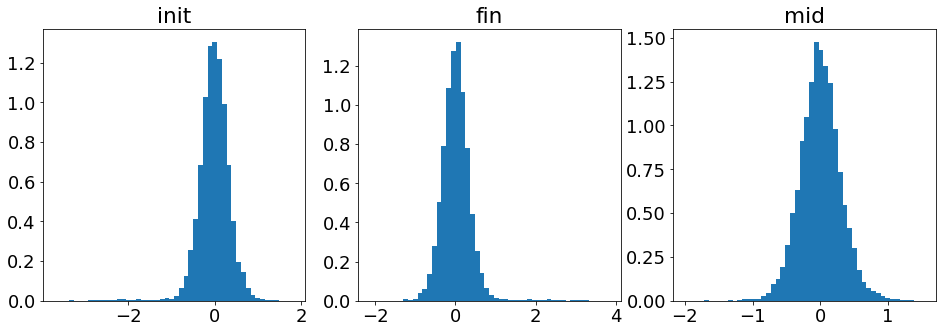

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

W = []
for i in range(3):
    with open('./pickles/W_avg_'+names[i]+'.pkl', 'rb') as f:
        W.append(pickle.load(f))
        
for i in range(3):
    ax[i].hist(W[i].flatten(), bins=50, density=True)
    ax[i].set_title(names[i])
    p = stats.normaltest(W[i].flatten())[1]
    print('p = {:g}'.format(p))
plt.show()

SpearmanrResult(correlation=-0.0028132592251232233, pvalue=0.780645687811256)
SpearmanrResult(correlation=0.6374057272827468, pvalue=0.0)
SpearmanrResult(correlation=0.6409374971206243, pvalue=0.0)


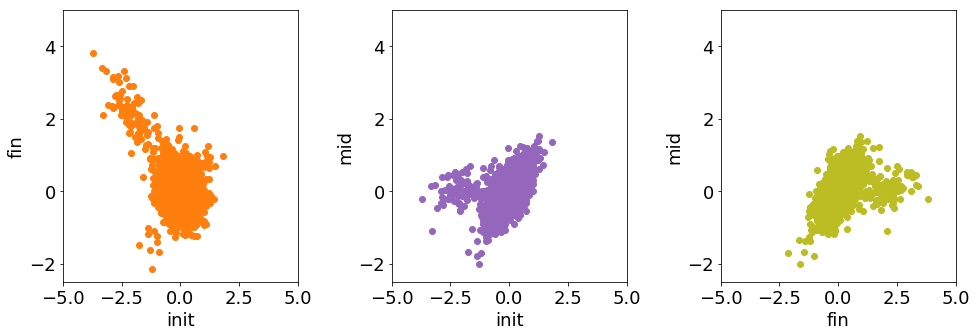

In [13]:
names = ["init", "fin", "mid"]
color = ['tab:orange', 'tab:purple', 'tab:olive']
import itertools as it

W_avg = []
for i in range(3):
    with open('./pickles/W_avg_'+names[i]+'.pkl', 'rb') as f:
        W_avg.append(pickle.load(f))
        
fig, ax = plt.subplots(1, 3, figsize=(16,5))
plt.subplots_adjust(wspace=0.4)
for i,(j,k) in enumerate(it.combinations(range(3), 2)):
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-2.5, 5)
    ax[i].scatter(W_avg[j], W_avg[k], c=color[i])
    ax[i].set_xlabel(names[j])
    ax[i].set_ylabel(names[k])
    print(stats.spearmanr(W_avg[j].flatten(), W_avg[k].flatten()))
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.rcParams['font.size'] = 18
# std = np.std(W, axis=0)
# plt.imshow(std, cmap='PiYG', origin='upper')
# plt.colorbar(fraction=0.045)
# plt.clim(0,np.percentile(std, 50))
# plt.show()

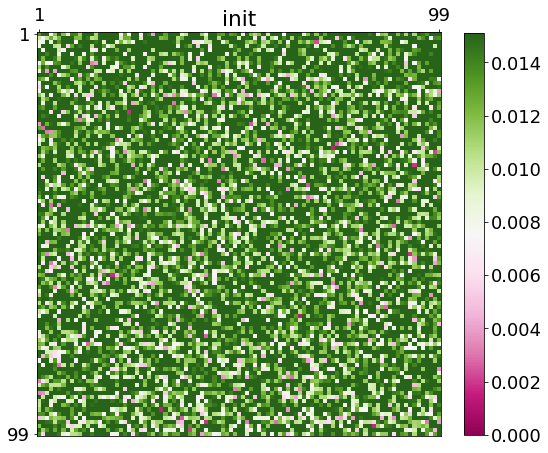

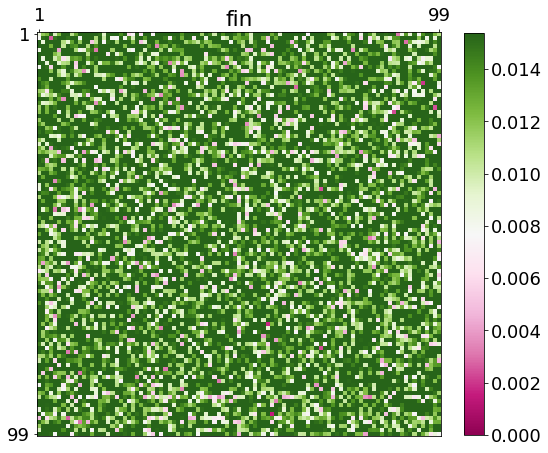

In [27]:
W_list = []
for i in range(3):
    with open('./pickles/W_list_'+names[i]+'.pkl', 'rb') as f:
        W_list.append(pickle.load(f))

for i in range(len(W_list)-1):
    plt.figure(figsize=(8,8))
    std = np.std(W_list[i], axis=0)
    plt.imshow(std, cmap='PiYG', origin='upper')
    plt.gca().xaxis.tick_top()
    plt.xticks([0, 98], ['1', '99'])
    plt.yticks([0, 98], ['1','99'])
    plt.colorbar(fraction=0.045)
    plt.clim(0, np.percentile(std, 50))
    plt.title(names[i])
plt.show()